# Dynamic Risk Budgeting

In [20]:
import numpy as np
import pandas as pd
import edhec_risk_kit as erk
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
n_scenarios = 5000
rates, zc_prices = erk.updated_cir(10, n_scenarios=n_scenarios, b=0.03, r_0=0.04, sigma=0.02)
price_eq  = erk.gbm(n_years=10, n_scenarios=n_scenarios, mu=0.07, sigma=0.15 )

In [22]:
rets_eq = price_eq.pct_change().dropna()
rets_zc = zc_prices.pct_change().dropna()
rets_7030b = erk.bt_mix(rets_eq, rets_zc, allocator=erk.fixedmix_allocator, w1=0.7)
pd.concat([
    erk.terminal_stats(rets_zc, name="ZC", floor=0.75),
    erk.terminal_stats(rets_eq, name="Eq", floor=0.75),
    erk.terminal_stats(rets_7030b, name="70/30", floor=0.75)
],axis=1).round(2)

,ZC,Eq,70/30
mean,1.45,1.93,1.77
std,0.00,0.94,0.59
p_breach,NaN,0.04,0.01
e_short,NaN,0.12,0.07
p_reach,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN


In [23]:
rets_floor75=erk.bt_mix(rets_eq, rets_zc, allocator=erk.floor_allocator, floor=0.75, zc_prices=zc_prices[1:])
pd.concat([
    erk.terminal_stats(rets_zc, name="ZC", floor=0.75),
    erk.terminal_stats(rets_eq, name="Eq", floor=0.75),
    erk.terminal_stats(rets_7030b, name="70/30", floor=0.75),
    erk.terminal_stats(rets_floor75, name="floor75", floor=0.75)
],axis=1).round(2)

,ZC,Eq,70/30,floor75
mean,1.45,1.93,1.77,1.92
std,0.00,0.94,0.59,0.95
p_breach,NaN,0.04,0.01,NaN
e_short,NaN,0.12,0.07,NaN
p_reach,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN


In [24]:
rets_floor75m1=erk.bt_mix(rets_eq, rets_zc, allocator=erk.floor_allocator, floor=0.75, zc_prices=zc_prices[1:],m=1)
rets_floor75m5=erk.bt_mix(rets_eq, rets_zc, allocator=erk.floor_allocator, floor=0.75, zc_prices=zc_prices[1:],m=5)
pd.concat([
    erk.terminal_stats(rets_zc, name="ZC", floor=0.75),
    erk.terminal_stats(rets_eq, name="Eq", floor=0.75),
    erk.terminal_stats(rets_7030b, name="70/30", floor=0.75),
    erk.terminal_stats(rets_floor75, name="floor75", floor=0.75),
    erk.terminal_stats(rets_floor75m1, name="floor75m1", floor=0.75),
    erk.terminal_stats(rets_floor75m5, name="floor75m5", floor=0.75)
],axis=1).round(4)

,ZC,Eq,70/30,floor75,floor75m1,floor75m5
mean,1.4489,1.9323,1.7745,1.9160,1.6846,1.9223
std,0.0000,0.9431,0.5925,0.9464,0.4546,0.9490
p_breach,NaN,0.0364,0.0078,NaN,NaN,NaN
e_short,NaN,0.1238,0.0689,NaN,NaN,NaN
p_reach,NaN,NaN,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN,NaN,NaN


# Risk Budgeting eith Drawdown Constraint

In [25]:
cashrate=0.02
monthly_cashreturn = (1+cashrate)**(1/12) -1
rets_cash=pd.DataFrame(data=monthly_cashreturn, index=rets_eq.index, columns=rets_eq.columns)
rets_maxdd25 = erk.bt_mix(rets_eq, rets_cash, allocator=erk.drawdown_allocator, maxdd=25)
tv_maxdd25 = erk.terminal_values(rets_maxdd25)
pd.concat([
    erk.terminal_stats(rets_zc, name="ZC", floor=0.75),
    erk.terminal_stats(rets_eq, name="Eq", floor=0.75),
    erk.terminal_stats(rets_7030b, name="70/30", floor=0.75),
    erk.terminal_stats(rets_floor75, name="floor75", floor=0.75),
    erk.terminal_stats(rets_floor75m1, name="floor75m1", floor=0.75),
    erk.terminal_stats(rets_floor75m5, name="floor75m5", floor=0.75),
    erk.terminal_stats(rets_maxdd25, name="MaxDD25", floor=0.75)
],axis=1).round(4)


,ZC,Eq,70/30,floor75,floor75m1,floor75m5,MaxDD25
mean,1.4489,1.9323,1.7745,1.9160,1.6846,1.9223,1.9323
std,0.0000,0.9431,0.5925,0.9464,0.4546,0.9490,0.9431
p_breach,NaN,0.0364,0.0078,NaN,NaN,NaN,0.0364
e_short,NaN,0.1238,0.0689,NaN,NaN,NaN,0.1238
p_reach,NaN,NaN,NaN,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
erk.summary_stats(rets_maxdd25)["Max Drawdown"].head()

0   -0.458809
1   -0.498232
2   -0.389862
3   -0.330564
4   -0.310665
Name: Max Drawdown, dtype: float64

In [27]:
erk.summary_stats(rets_maxdd25)["Max Drawdown"].min()

-0.7485931520864767

In [28]:
tv_eq = erk.terminal_values(rets_eq)
tv_zc = erk.terminal_values(rets_zc)
tv_7030b = erk.terminal_values(rets_7030b)
tv_floor75 = erk.terminal_values(rets_floor75)
tv_floor75m1 = erk.terminal_values(rets_floor75m1)

<Figure size 1200x600 with 0 Axes>

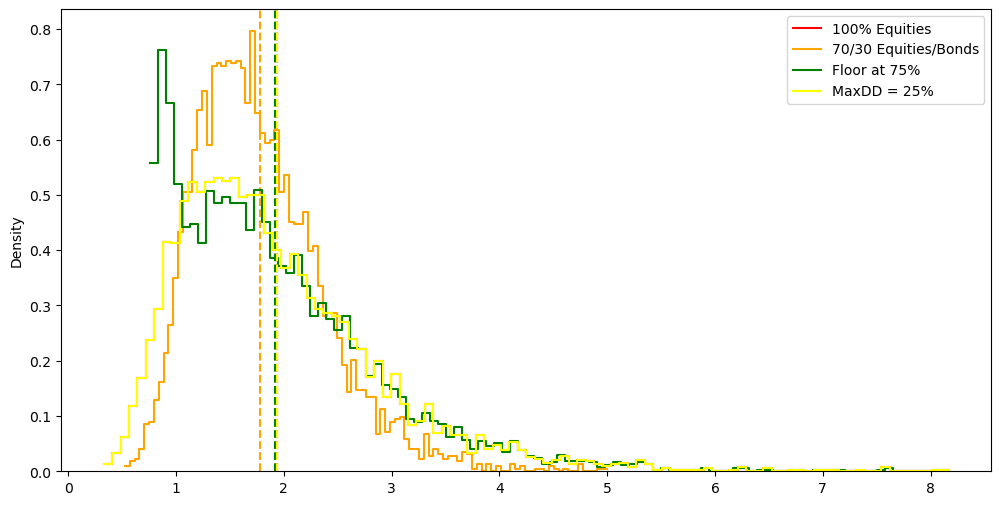

In [31]:
plt.figure(figsize=(12, 6))
sns.histplot(tv_eq, color="red", label="100% Equities", bins=100, stat="density", element="step", fill=False)
plt.axvline(tv_eq.mean(), ls="--", color="red")
sns.histplot(tv_7030b, color="orange", label="70/30 Equities/Bonds", bins=100, stat="density", element="step", fill=False)
plt.axvline(tv_7030b.mean(), ls="--", color="orange")
sns.histplot(tv_floor75, color="green", label="Floor at 75%", bins=100, stat="density", element="step", fill=False)
plt.axvline(tv_floor75.mean(), ls="--", color="green")
sns.histplot(tv_maxdd25, color="yellow", label="MaxDD = 25%", bins=100, stat="density", element="step", fill=False)
plt.axvline(tv_maxdd25.mean(), ls="--", color="yellow")
plt.legend()
plt.show()

/Applications/SelfStudy/PythonForPortfolio/Module 4/edhec_risk_kit.py:65: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ind = pd.read_csv("../data/ind30_m_vw_rets.csv", header = 0, index_col = 0, parse_dates= True) /100
/Applications/SelfStudy/PythonForPortfolio/Module 4/edhec_risk_kit.py:57: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ind = pd.read_csv("../data/ind30_m_nfirms.csv", header = 0, index_col = 0, parse_dates= True)
/Applications/SelfStudy/PythonForPortfolio/Module 4/edhec_risk_kit.py:50: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ind = pd.read_csv("../data

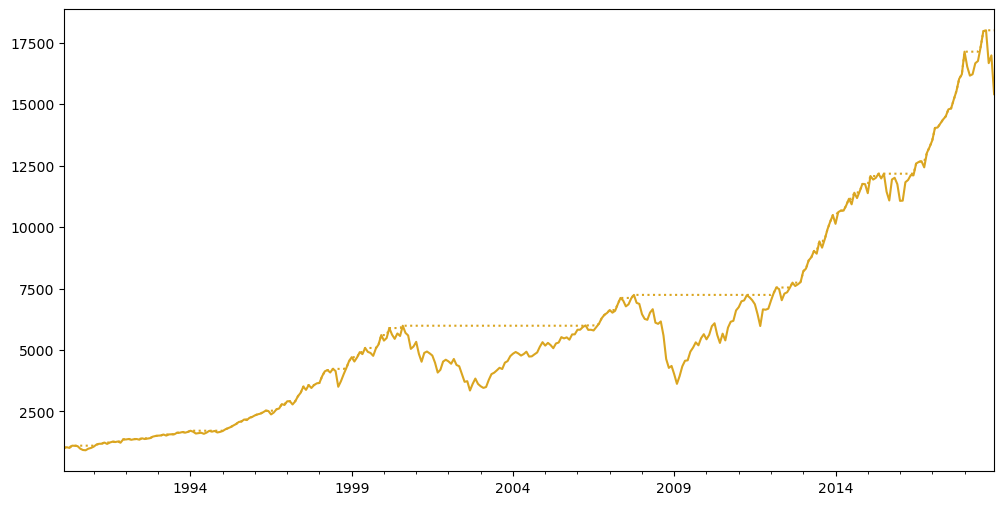

In [40]:
wealth_tmi = erk.get_total_market_index_returns()["1990":]  # これはWealth
rets_tmi = wealth_tmi.pct_change().dropna()                 # これがreturns
dd_tmi = erk.drawdown(rets_tmi)
ax=dd_tmi["Wealth"].plot(figsize=(12,6), ls="-", color="goldenrod")
dd_tmi["Peaks"].plot(ax=ax, ls=":", color="goldenrod")
plt.show()


/Applications/SelfStudy/PythonForPortfolio/Module 4/edhec_risk_kit.py:65: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ind = pd.read_csv("../data/ind30_m_vw_rets.csv", header = 0, index_col = 0, parse_dates= True) /100
/Applications/SelfStudy/PythonForPortfolio/Module 4/edhec_risk_kit.py:57: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ind = pd.read_csv("../data/ind30_m_nfirms.csv", header = 0, index_col = 0, parse_dates= True)
/Applications/SelfStudy/PythonForPortfolio/Module 4/edhec_risk_kit.py:50: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ind = pd.read_csv("../data

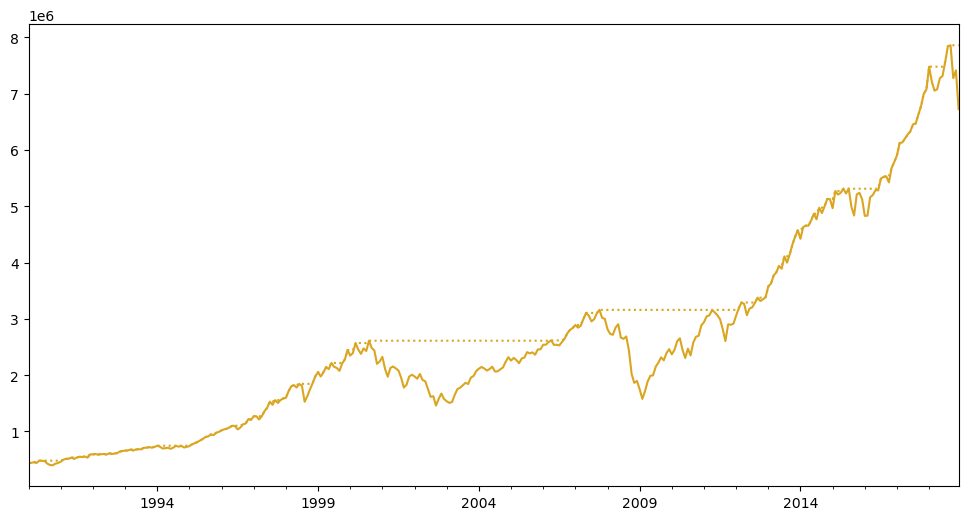

In [41]:
wealth = erk.get_total_market_index_returns()["1990":]
peaks = wealth.cummax()

ax = wealth.plot(figsize=(12,6), ls="-", color="goldenrod")
peaks.plot(ax=ax, ls=":", color="goldenrod")
plt.show()

In [44]:
cashrate=0.03
monthly_cashreturn = (1+cashrate)**(1/12) -1
rets_cash = pd.DataFrame(monthly_cashreturn, index=rets_tmi.index, columns=[0])

rets_maxdd25 = erk.bt_mix(rets_tmi.to_frame(), rets_cash,
                          allocator=erk.drawdown_allocator, maxdd=0.25, m=5)
dd_25 = erk.drawdown(rets_maxdd25[0])

ax = dd_tmi["Wealth"].plot(figsize=(12,6), ls="-", color="goldenrod",label="Market", legend=True)
dd_tmi["Peaks"].plot(ax=ax, ls="-", color="goldenrod")
dd_25["Wealth"].plot(ax=ax, label="MaxDD 25%", color="cornflowblue", legend=True)
dd_25["Peaks"].plot(ax=ax, color="cornflowblue", ls="-")

ValueError: setting an array element with a sequence.